In [1]:
#Extracts cifar-10-python.tar.gz file
# Note: Tensorflow has inbuilt functions for accessing cifar10 data but I wanted to learn to manually handle a dataset  

#Only execute if not yet extracted

import tarfile
tar = tarfile.open('Data/cifar-10-python.tar.gz','r')
tar.extractall()
tar.close()

In [2]:
#for unplickling CIFAR10 Dataset

def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

batch1 = unpickle('cifar-10-batches-py/data_batch_1') #Chosen as training sample
batch2 = unpickle('cifar-10-batches-py/data_batch_2') #Chosen as training sample
batch3 = unpickle('cifar-10-batches-py/data_batch_3') #Chosen as training sample
batch4 = unpickle('cifar-10-batches-py/data_batch_4') #Chosen as training sample
batch5 = unpickle('cifar-10-batches-py/data_batch_5') #Chosen as training sample
test = unpickle('cifar-10-batches-py/test_batch') #Chosen as test sample (same data for validation)
classes = unpickle('cifar-10-batches-py/batches.meta') #keyword for label = label_names

trainingSamples = len(batch1['data'])+len(batch2['data'])+len(batch3['data'])+len(batch4['data'])+len(batch5['data'])
testingSamples = len(test['data'])

print("Total Training Samples: %d"%trainingSamples)
print("Total Testing Samples: %d"%testingSamples)
print("Classes: "+str(classes['label_names']))


Total Training Samples: 50000
Total Testing Samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
#Information about CIFAR10 from https://www.cs.toronto.edu/~kriz/cifar.html

"""
Loaded in this way, each of the batch files contains a dictionary with the following elements:

data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. 
The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. 
The image is stored in row-major order, so that the first 32 entries of the array are the red channel values 
of the first row of the image.

"""

#I will try to rearrange the data (10000x3072) in a proper 10000x32x32x3 format (3 = channels, X,Y dims = 32,32)

#initialize

import numpy as np

X_train = np.zeros((trainingSamples,32,32,3))
Y_train = np.zeros((trainingSamples))
X_test = np.zeros((testingSamples,32,32,3))
Y_test = []

b1l = len(batch1['data'])
b2l = len(batch2['data'])
b3l = len(batch3['data'])
b4l = len(batch4['data'])
b5l = len(batch5['data'])
tl = len(test['data'])

# I intend to convert each batch from 10000x3072 to 10000x32x32x3 format but directly reshaping into that format
# makes each of the images strange looking because the pixel co-efficients don't get properly arranged in that way.
# Instead reshaping to 10000x3x32x32 format works fine. So that's what I did first.

b1 = batch1['data'][...].reshape((b1l,3,32,32))
b2 = batch2['data'][...].reshape((b2l,3,32,32))
b3 = batch3['data'][...].reshape((b3l,3,32,32))
b4 = batch4['data'][...].reshape((b4l,3,32,32))
b5 = batch5['data'][...].reshape((b5l,3,32,32))
t = test['data'][...].reshape((tl,3,32,32))

# Now the images are in 3x32x32 (channels first format) but I want those in 32x32x3 (channels last format)
# To do that I simply transponse the image matrices in the specific order of axes and I get the output in 
# my desired format 10000x32x32x3

b1 = np.transpose(b1,(0,2,3,1))
b2 = np.transpose(b2,(0,2,3,1))
b3 = np.transpose(b3,(0,2,3,1))
b4 = np.transpose(b4,(0,2,3,1))
b5 = np.transpose(b5,(0,2,3,1))
t = np.transpose(t,(0,2,3,1))

# (To keep things simple, I didn't make a separate validation and testing set,)

X_train = np.concatenate((b1,b2,b3,b4,b5))
Y_train = np.concatenate((batch1['labels'],batch2['labels'],batch3['labels'],batch4['labels'],batch5['labels']))

X_test = t
Y_test = test['labels']
Y_test = np.array(Y_test)
        
print ("Shape of Training Samples (input and output): "+str(X_train.shape)+" "+str(Y_train.shape))
print ("Shape of Testing Samples (input and output): "+str(X_test.shape)+" "+str(Y_test.shape))


Shape of Training Samples (input and output): (50000, 32, 32, 3) (50000,)
Shape of Testing Samples (input and output): (10000, 32, 32, 3) (10000,)


Some sample training images with their labels: 



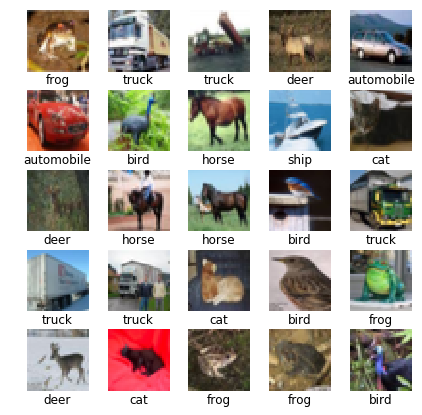

In [4]:
from scipy.misc import toimage
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
 
print "Some sample training images with their labels: \n"

def picgrid(X_train,gray=0):
    plt.figure(figsize=(7,7))
    ax=[]
    for i in xrange(0,25):
        img = toimage(X_train[i])
        ax.append(plt.subplot(5,5,i+1))
        ax[i].set_title( classes['label_names'][int(Y_train[i])],y=-0.3)
        ax[i].set_axis_off()
        if gray==0:
            plt.imshow(img)
        else:
            plt.imshow(img,cmap='gray')
    plt.subplots_adjust(hspace=0.3)
    plt.axis('off')
    plt.show()

picgrid(X_train)

In [5]:
#Convert to float32

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Pictures after Global Contrast Normalization: 


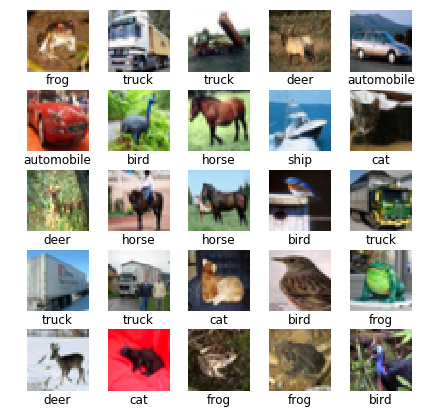

In [6]:
#Source: https://datascience.stackexchange.com/questions/15110/how-to-implement-global-contrast-normalization-in-python
#Applying global_contrast_normalization 

X_train_gcn = np.zeros((X_train.shape))
X_test_gcn = np.zeros((X_test.shape))

def global_contrast_normalization(img,s, lmda, epsilon):
    X = np.array(img)
    X_average = np.mean(X)
    X = X - X_average
    contrast = np.sqrt(lmda + np.mean(X**2))
    X = s * X / max(contrast, epsilon)
    return X

for i in xrange(0,len(X_train)):
    X_train_gcn[i] = global_contrast_normalization(X_train[i],1, 10, 0.000000001)

for i in xrange(0,len(X_test)):
    X_test_gcn[i] = global_contrast_normalization(X_test[i],1, 10, 0.000000001)
    
print "Pictures after Global Contrast Normalization: "

picgrid(X_train_gcn)

In [7]:
#One hot encode output samples.

Y_train1H = np.zeros((Y_train.shape[0],len(classes['label_names'])))
Y_test1H = np.zeros((Y_test.shape[0],len(classes['label_names'])))

for i in range(0,len(Y_train)):
    Y_train1H[i][int(Y_train[i])] = 1

for i in range(0,len(Y_test)):
    Y_test1H[i][int(Y_test[i])] = 1
    

In [8]:
#Saving processed data in another file.

import h5py

file = h5py.File('processed_data.h5','w')
file.create_dataset('X_train', data=X_train_gcn)
file.create_dataset('X_test', data=X_test_gcn)
file.create_dataset('Y_train', data=Y_train1H)
file.create_dataset('Y_test', data=Y_test1H)

file.close()